# Basic usage and visualization 
> Runtime: about 30s.

This notebook is run on the BMMC dataset.

In [1]:
import scanpy as sc
from sklearn import metrics

import scyan

Global seed set to 0


## Model initialization and fitting
> If you use your own dataset, use `Scyan` default parameters first.

In [2]:
adata, marker_pop_matrix = scyan.data.load("bmmc") # Load data

model = scyan.Scyan(adata, marker_pop_matrix, temperature=2.5, hidden_size=32, n_hidden_layers=8, n_layers=8, prior_std=0.35)

INFO:scyan.model:Initialized Scyan model with N=61725 cells, P=19 populations and M=13 markers. No covariate provided.


In [3]:
model.fit(min_delta=2, patience=2)

INFO:scyan.model:Training scyan with the following hyperparameters:
"alpha_batch_effect": 50.0
"batch_key":          None
"batch_ref":          None
"batch_size":         16384
"hidden_size":        32
"lr":                 0.001
"max_samples":        200000
"mmd_max_samples":    2048
"modulo_temp":        2
"n_hidden_layers":    8
"n_layers":           8
"prior_std":          0.35
"temperature":        2.5

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 149 K 
---------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
0.597     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:scyan.model:Successfully ended traning.


Scyan model with N=61725 cells, P=19 populations and M=13 markers. No covariate provided.

## Compare results to the ground truth

In [4]:
model.predict() # Predictions are saved in adata.obs.scyan_pop by default

print(f"Model accuracy: {metrics.accuracy_score(model.adata.obs.cell_type, model.adata.obs.scyan_pop):.3f}")
print(f"Model f1-score: {metrics.f1_score(model.adata.obs.cell_type, model.adata.obs.scyan_pop, average='macro'):.3f}")
print(f"Model balanced accuracy: {metrics.balanced_accuracy_score(model.adata.obs.cell_type, model.adata.obs.scyan_pop):.3f}")

Model accuracy: 0.967
Model f1-score: 0.813
Model balanced accuracy: 0.823


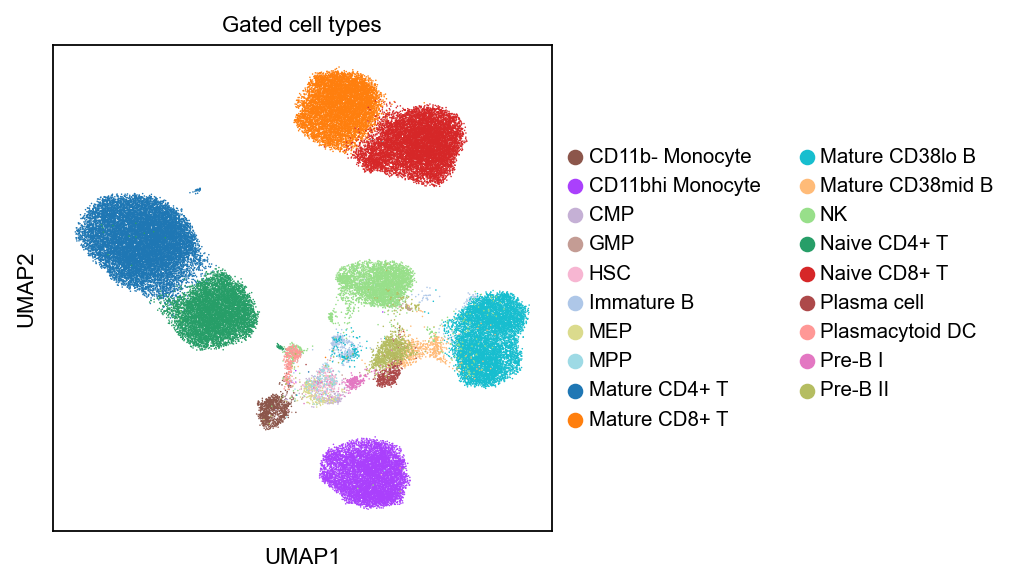

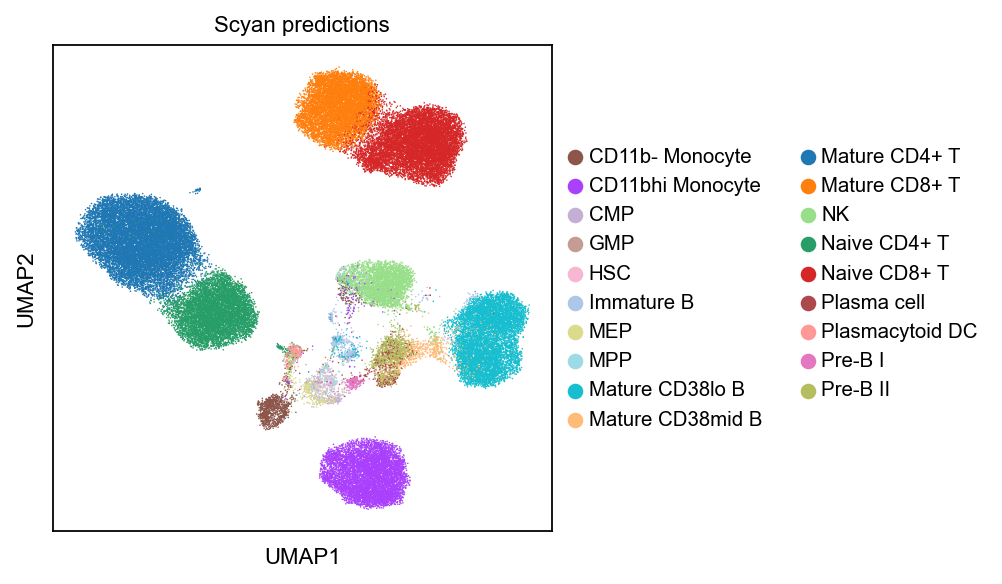

In [5]:
sc.pl.umap(model.adata, color="cell_type", palette=model.adata.uns["palette"], title="Gated cell types")
sc.pl.umap(model.adata, color="scyan_pop", palette=model.adata.uns["palette"], title="Scyan predictions")

## Visualization and interpretability

### Latent expressions for all populations

Expressions close to $-1$ represent negative expressions, while expressions close to $1$ represent positive expressions. Thus, $0.5$ can be considered as a low expression.

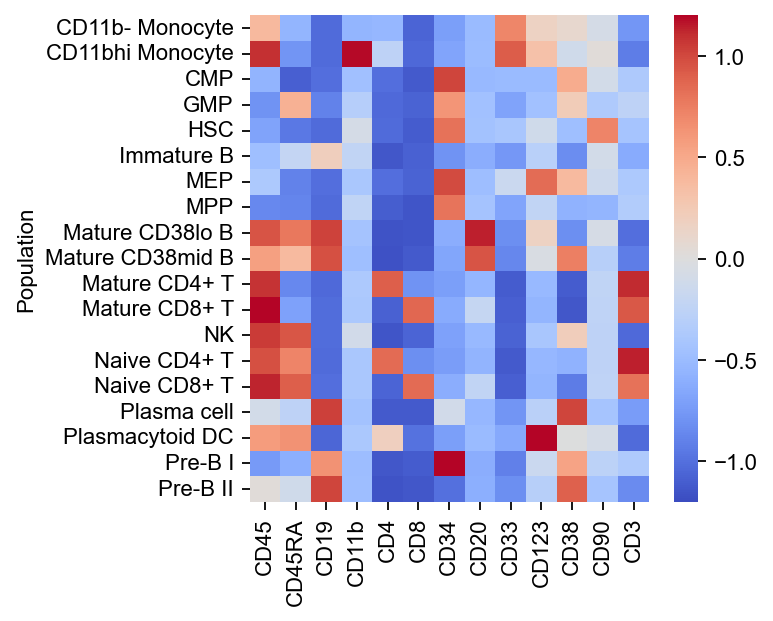

In [6]:
scyan.plot.latent_heatmap(model)

### Pairwise scatter plots
B cells populations separation on 6 scatter plots.

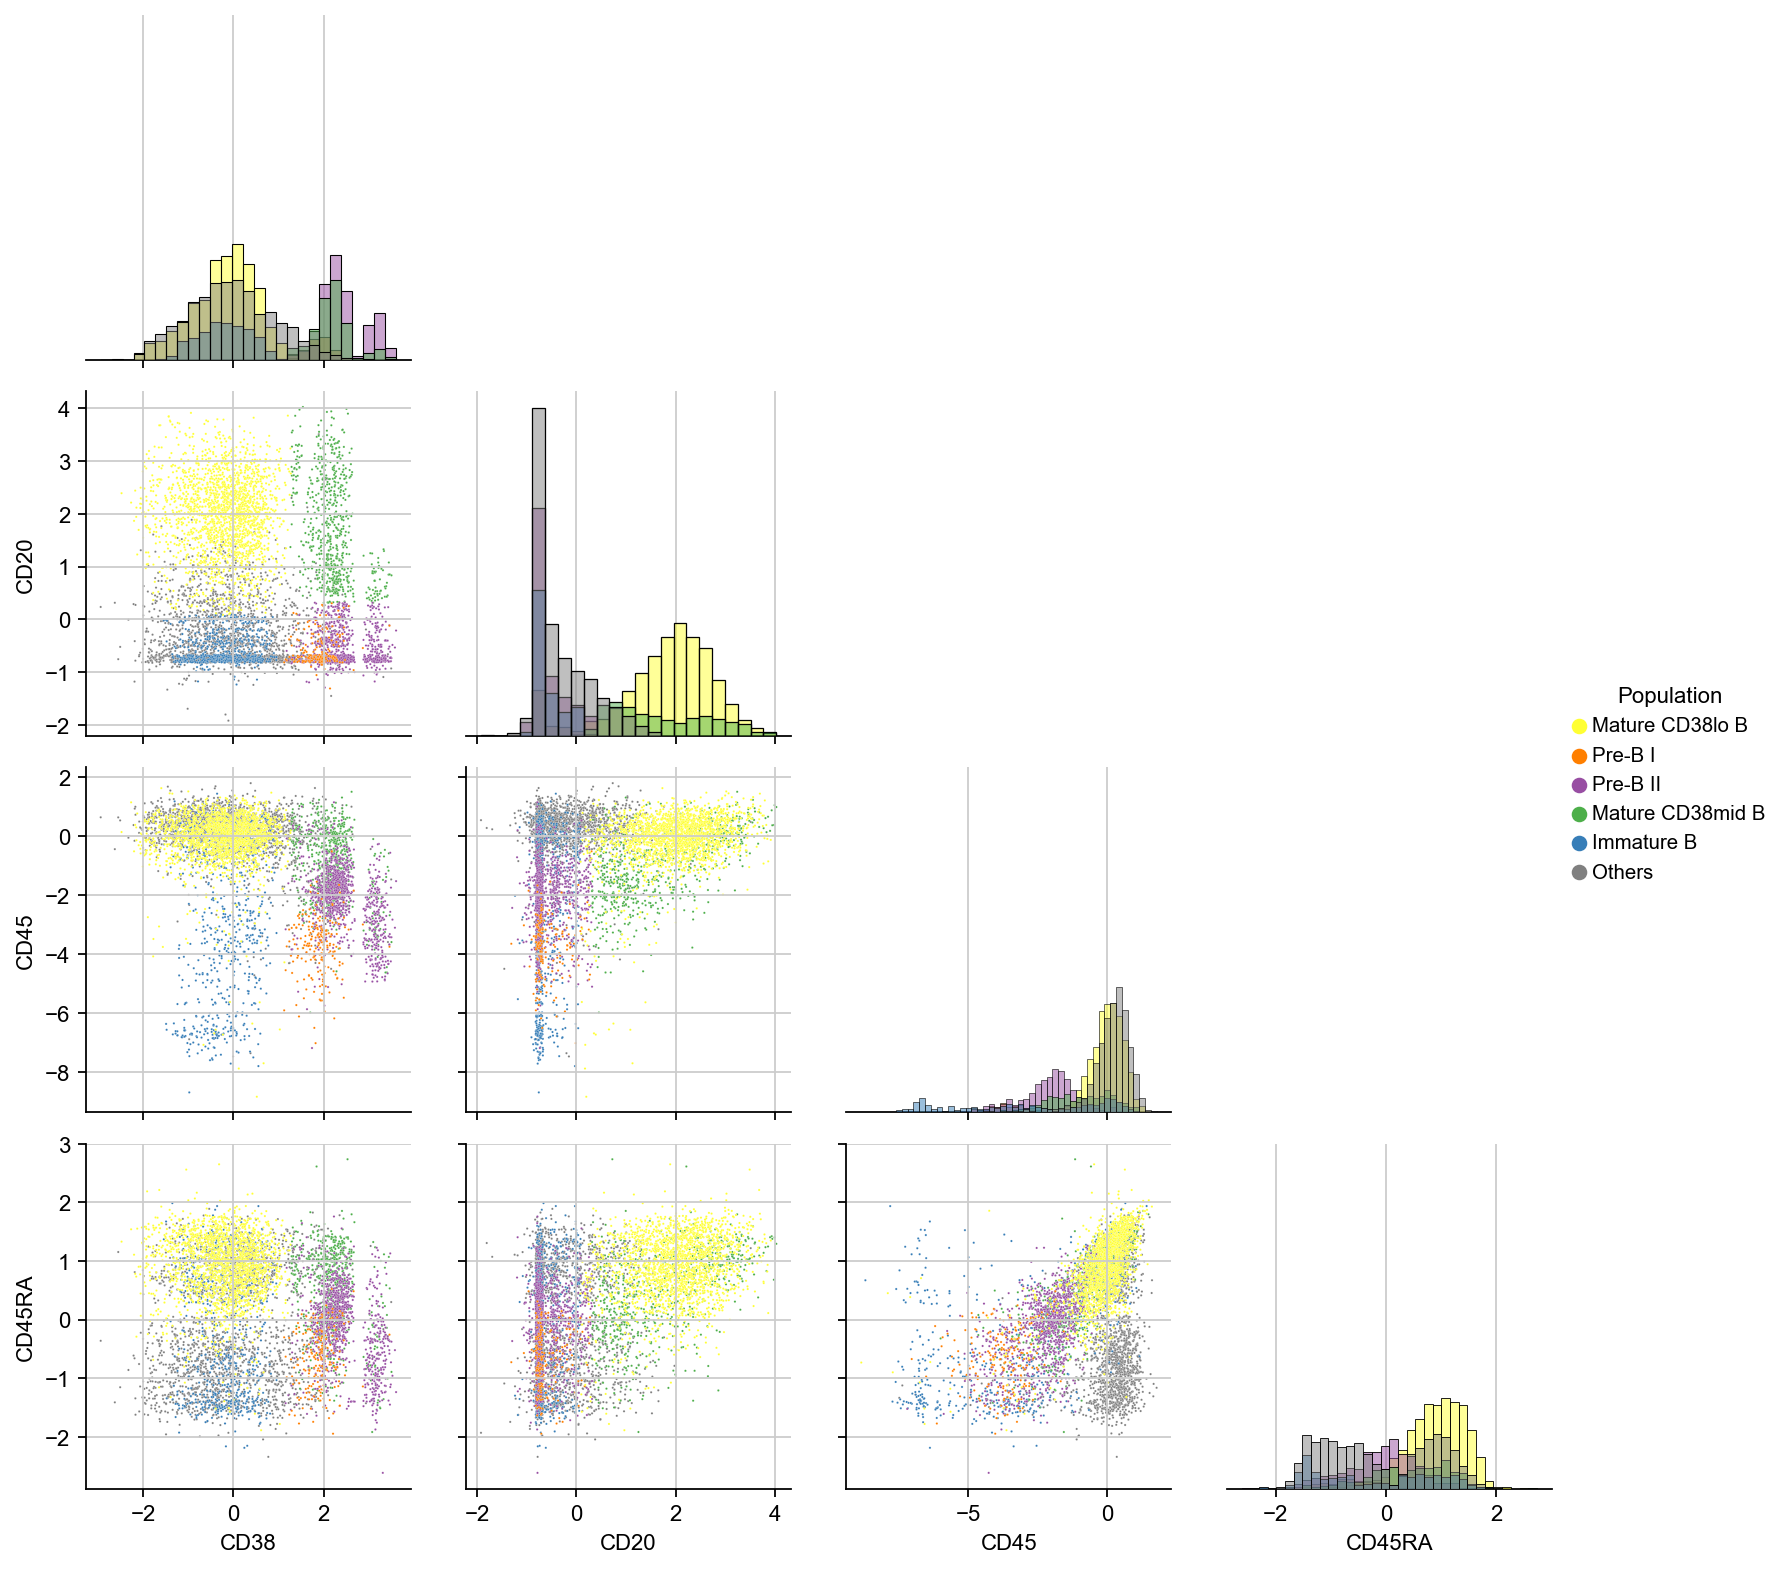

In [7]:
b_cells = ["Mature CD38lo B", "Pre-B I", "Pre-B II", "Mature CD38mid B", "Immature B"]
scyan.plot.scatter(model, b_cells, n_markers=4)

### Model interpretability for one population
Let's now consider one specific population: Mature CD38lo B cells.

In [8]:
population = "Mature CD38lo B"

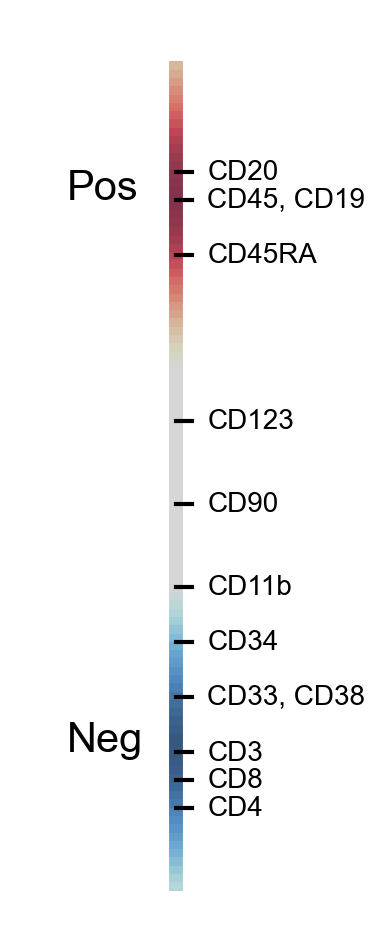

In [9]:
scyan.plot.latent_expressions(model, population)

Interpret why Scyan predicted Mature CD38lo B cells and not another population. Dark values correspond to a marker that reduces the confidence in predicting a population.

E.g., the dark value on (Mature CD38mid B, CD38) means that the expressions of CD20 of the targeted cells (low / neg) reduced the model confidence to predict Mature CD38mid B, as intended.

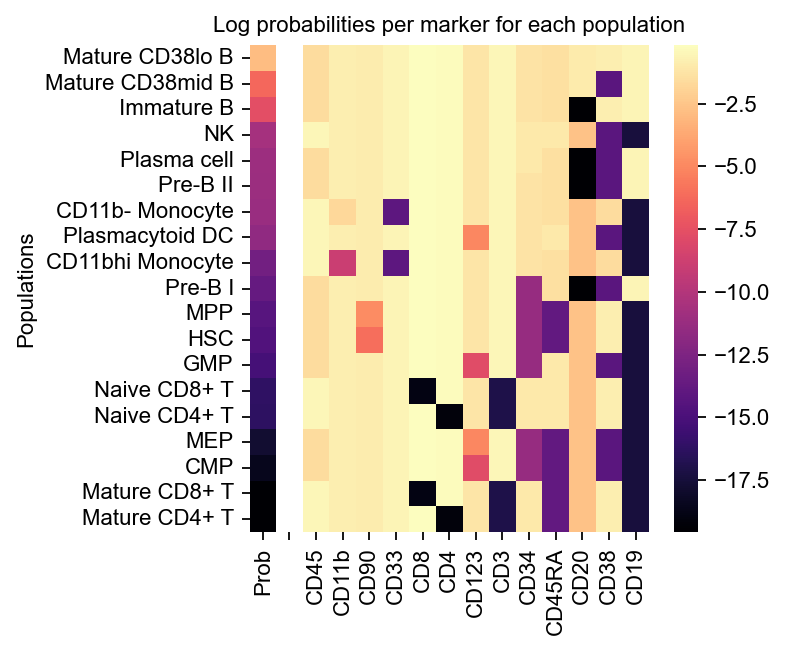

In [10]:
scyan.plot.probs_per_marker(model, population)